# Jeffress Coincidence Bank for Continuous Range Estimation (snntorch)

Refactored notebook: from 3-class classification to a place-coded Jeffress bank that maps pulse–echo delay (0–100 ms) onto a spatial output layer. Output neuron index encodes estimated range; multiple spikes yield a continuous estimate via averaging.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from snntorch import surrogate, spikeplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Synthetic Data (Exact Delay Labels)
- Input: 2 channels (pulse at t=0, echo at t=delay)
- Delay: integer in [0, 100]
- Label: the delay value itself (place code target index).

In [3]:
time_steps = 120  # covers up to 100 ms delay with margin
max_delay = 100

def generate_bat_data(num_samples: int):
    data = torch.zeros(num_samples, time_steps, 2)
    labels = torch.zeros(num_samples, dtype=torch.long)
    for i in range(num_samples):
        delay = np.random.randint(0, max_delay + 1)
        jitter = np.random.choice([-1, 0, 1])
        delay = int(np.clip(delay + jitter, 0, max_delay))
        data[i, 0, 0] = 1.0          # pulse at t=0
        data[i, delay, 1] = 1.0       # echo at t=delay
        labels[i] = delay
    return data, labels

num_samples = 3000
data, labels = generate_bat_data(num_samples)
split = int(0.8 * num_samples)
train_data, test_data = data[:split], data[split:]
train_labels, test_labels = labels[:split], labels[split:]

train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=128, shuffle=False)
print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

Train samples: 2400, Test samples: 600


## Part 2: Jeffress SNN Architecture
- Hidden: dense 200 LIF units (surrogate gradients)
- Output: 101 neurons (0..100) as place code
- Loss: CrossEntropy on spike counts per neuron (rate).

In [4]:
beta = 0.97
hidden_size = 200
out_neurons = max_delay + 1  # 0..100 inclusive

class JeffressSNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Surrogate gradient lets gradients flow through spike discontinuity
        grad_fn = surrogate.fast_sigmoid()
        self.fc1 = nn.Linear(2, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=grad_fn)
        self.fc2 = nn.Linear(hidden_size, out_neurons)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=grad_fn)

    def forward(self, x):
        # Supports [batch,time,feat] or a single step [batch,feat]
        if x.dim() == 2:
            h1 = self.fc1(x)
            spk1, mem1 = self.lif1(h1)
            h2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(h2)
            return spk2

        batch_size = x.size(0)
        mem1 = torch.zeros(batch_size, hidden_size, device=x.device)
        mem2 = torch.zeros(batch_size, out_neurons, device=x.device)
        spk2_rec = []
        for t in range(x.size(1)):
            cur = x[:, t, :]
            h1 = self.fc1(cur)
            spk1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(h2, mem2)
            spk2_rec.append(spk2)
        return torch.stack(spk2_rec, dim=1)  # [batch, time, out_neurons]

model = JeffressSNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)
num_epochs = 60


## Part 3: Training Loop
- Spike counts over time become logits for CrossEntropyLoss.
- Track loss and test MAE over epochs.

In [5]:
from snntorch import utils

# Debug: inspect a single batch
x_dbg, y_dbg = next(iter(train_loader))
print('Batch shape:', x_dbg.shape, 'Labels shape:', y_dbg.shape)
# Expect [batch, time, features]; if not, permute helper below
if x_dbg.dim() == 3:
    print('Time dimension position (assuming batch-first): time axis=1, features axis=2')
else:
    print('Unexpected input rank:', x_dbg.dim())

def to_time_first(x):
    # convert [batch, time, features] -> [time, batch, features]
    if x.dim() == 3:
        return x.permute(1,0,2)
    raise ValueError('Input must be 3D [batch,time,feat]')

x_time_first = to_time_first(x_dbg)
print('After permute to time-first:', x_time_first.shape)


Batch shape: torch.Size([64, 120, 2]) Labels shape: torch.Size([64])
Time dimension position (assuming batch-first): time axis=1, features axis=2
After permute to time-first: torch.Size([120, 64, 2])


Mean Vm before echo min=-6.910
Voltage decays <0.1 before echo -> increase beta_high toward 0.99.


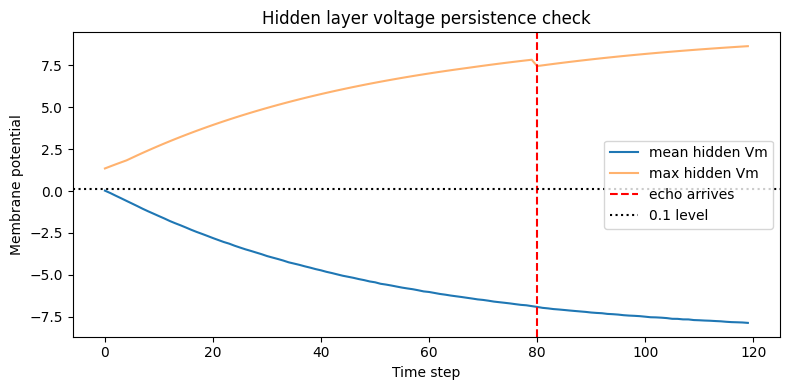

In [6]:
# Re-init SNN with persistent betas, learnable taus, and Gaussian targets
beta_high = 0.98  # high persistence; increase toward 0.99 if voltage still decays
hidden_threshold = 0.5  # hidden layer fires easily
sigma_target = 2.0
hidden_size = 200
out_neurons = max_delay + 1  # 0..100 inclusive

# Soft target: Gaussian bump around correct delay
mse_loss = nn.MSELoss()

def gaussian_targets(y, num_classes=out_neurons, sigma=sigma_target, device=None):
    device = device or y.device
    centers = y.to(device).float()
    positions = torch.arange(num_classes, device=device).float().unsqueeze(0)
    targets = torch.exp(-0.5 * ((positions - centers.unsqueeze(1)) / sigma) ** 2)
    targets = targets / (targets.max(dim=1, keepdim=True).values + 1e-8)
    return targets


def gaussian_mse_loss(logits, labels, sigma=sigma_target):
    target = gaussian_targets(labels, out_neurons, sigma=sigma, device=logits.device)
    return mse_loss(logits, target)


class JeffressSNN(nn.Module):
    def __init__(self):
        super().__init__()
        grad_fn = surrogate.fast_sigmoid()
        self.fc1 = nn.Linear(2, hidden_size)
        self.lif1 = snn.Leaky(
            beta=beta_high,
            threshold=hidden_threshold,
            spike_grad=grad_fn,
            learn_beta=True,
        )
        self.fc2 = nn.Linear(hidden_size, out_neurons)
        self.lif2 = snn.Leaky(
            beta=beta_high,
            spike_grad=grad_fn,
            learn_beta=True,
        )

    def forward(self, x):
        # Supports [batch,time,feat] or a single step [batch,feat]
        if x.dim() == 2:
            h1 = self.fc1(x)
            spk1, mem1 = self.lif1(h1)
            h2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(h2)
            return spk2

        batch_size = x.size(0)
        mem1 = torch.zeros(batch_size, hidden_size, device=x.device)
        mem2 = torch.zeros(batch_size, out_neurons, device=x.device)
        spk2_rec = []
        for t in range(x.size(1)):
            cur = x[:, t, :]
            h1 = self.fc1(cur)
            spk1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(h2, mem2)
            spk2_rec.append(spk2)
        return torch.stack(spk2_rec, dim=1)


model = JeffressSNN().to(device)
criterion = gaussian_mse_loss
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Current-injection debug: long delay to verify voltage persists until echo arrives
long_delay = 80
debug_sample = torch.zeros(1, time_steps, 2, device=device)
debug_sample[0, 0, 0] = 1.0  # pulse
debug_sample[0, long_delay, 1] = 1.0  # echo

model.eval()
with torch.no_grad():
    mem1 = torch.zeros(1, hidden_size, device=device)
    mem_trace = []
    for t in range(time_steps):
        h1 = model.fc1(debug_sample[:, t, :])
        spk1, mem1 = model.lif1(h1, mem1)
        mem_trace.append(mem1.squeeze(0).cpu().numpy())
    mem_trace = np.stack(mem_trace, axis=0)
    mean_mem = mem_trace.mean(axis=1)
    max_mem = mem_trace.max(axis=1)

plt.figure(figsize=(8, 4))
plt.plot(mean_mem, label='mean hidden Vm')
plt.plot(max_mem, label='max hidden Vm', alpha=0.6)
plt.axvline(long_delay, color='r', linestyle='--', label='echo arrives')
plt.axhline(0.1, color='k', linestyle=':', label='0.1 level')
plt.xlabel('Time step')
plt.ylabel('Membrane potential')
plt.title('Hidden layer voltage persistence check')
plt.legend()
plt.tight_layout()

min_before_echo = float(mean_mem[: long_delay + 1].min())
print(f'Mean Vm before echo min={min_before_echo:.3f}')
if min_before_echo < 0.1:
    print('Voltage decays <0.1 before echo -> increase beta_high toward 0.99.')


In [7]:
def decode_spikes(spikes: torch.Tensor):
    """spikes: [batch, time, out_neurons] -> continuous distance estimate per sample."""
    counts = spikes.sum(dim=1)  # [batch, out_neurons]
    total = counts.sum(dim=1, keepdim=True) + 1e-6
    weighted = (counts * torch.arange(out_neurons, device=counts.device)).sum(dim=1)
    avg_idx = weighted / total.squeeze(1)
    # If no spikes, fallback to argmax of counts (which will be zero; argmax returns 0)
    return avg_idx

def evaluate(model, loader):
    model.eval()
    maes = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            spk_out = model(x)
            preds = decode_spikes(spk_out)
            mae = (preds - y.float()).abs().mean().item()
            maes.append(mae)
    return float(np.mean(maes))

train_losses = []
test_maes = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        spk_out = model(x)
        # Rate code as logits for CE
        logits = spk_out.sum(dim=1)  # [batch, out_neurons]
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    mae = evaluate(model, test_loader)
    test_maes.append(mae)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Test MAE: {mae:.2f}")

Epoch 10/60 | Loss: 0.0357 | Test MAE: 51.06
Epoch 20/60 | Loss: 0.0404 | Test MAE: 20.01
Epoch 30/60 | Loss: 0.0437 | Test MAE: 47.65
Epoch 40/60 | Loss: 0.0428 | Test MAE: 46.97
Epoch 50/60 | Loss: 0.0522 | Test MAE: 47.83
Epoch 60/60 | Loss: 0.0623 | Test MAE: 30.02


## Part 4: Evaluation & Visualization
- Scatter: true vs. predicted delay
- Error histogram
- Jeffress raster: sweep delays 0..100, plot output-layer spikes across the population.

In [8]:
from snntorch import utils

def train_epoch(net, loader, optimizer, criterion):
    net.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        # Ensure time-first shape [time, batch, features]
        x_tbf = x.permute(1,0,2)
        utils.reset(net)  # reset state per batch
        spk_rec = []
        for t in range(x_tbf.size(0)):
            spk = net(x_tbf[t])
            spk_rec.append(spk)
        spk_rec = torch.stack(spk_rec, dim=0)  # [time, batch, out_neurons]
        logits = spk_rec.sum(dim=0)  # [batch, out_neurons]
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_mae(net, loader):
    net.eval()
    maes = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            x_tbf = x.permute(1,0,2)
            utils.reset(net)
            spk_rec = []
            for t in range(x_tbf.size(0)):
                spk = net(x_tbf[t])
                spk_rec.append(spk)
            spk_rec = torch.stack(spk_rec, dim=0)
            preds = decode_spikes(spk_rec.permute(1,0,2))  # back to [batch,time,out] for decode
            maes.append((preds - y.float()).abs().mean().item())
    return float(np.mean(maes))

train_losses = []
test_maes = []
for epoch in range(num_epochs):
    tr_loss = train_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(tr_loss)
    mae = eval_mae(model, test_loader)
    test_maes.append(mae)
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {tr_loss:.4f} | Test MAE: {mae:.2f}')


Epoch 10/60 | Loss: 1.6009 | Test MAE: 26.16
Epoch 20/60 | Loss: 0.0561 | Test MAE: 47.26
Epoch 30/60 | Loss: 0.0975 | Test MAE: 26.15
Epoch 40/60 | Loss: 0.1670 | Test MAE: 24.47
Epoch 50/60 | Loss: 0.2586 | Test MAE: 23.55
Epoch 60/60 | Loss: 0.2593 | Test MAE: 43.27
